### Importing libraries


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import joblib

### Data import and preprocessing

In [3]:
#Import the Dataset
df= pd.read_csv("/kaggle/input/phishingemails/Phishing_Email.csv")
df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [4]:
#Check NAN values
df.isna().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [5]:
nan_rows = df[df.isna().any(axis=1)]
nan_rows

,Unnamed: 0,Email Text,Email Type
31,31,NaN,Phishing Email
387,387,NaN,Phishing Email
1883,1883,NaN,Phishing Email
2049,2049,NaN,Phishing Email
2451,2451,NaN,Phishing Email
2972,2972,NaN,Phishing Email
3627,3627,NaN,Phishing Email
3806,3806,NaN,Phishing Email
5763,5763,NaN,Phishing Email
6299,6299,NaN,Phishing Email


In [6]:
#Delete Na values
df = df.dropna()
print(df.isna().sum())

Unnamed: 0    0
Email Text    0
Email Type    0
dtype: int64


In [7]:
#check duplicate values
df.duplicated().sum()

0

In [8]:
#shape of the dataset
df.shape

(18634, 3)

In [9]:
# Count occurrences of each type of Email.
email_type_counts = df['Email Type'].value_counts()
print(email_type_counts)


Email Type
Safe Email        11322
Phishing Email     7312
Name: count, dtype: int64


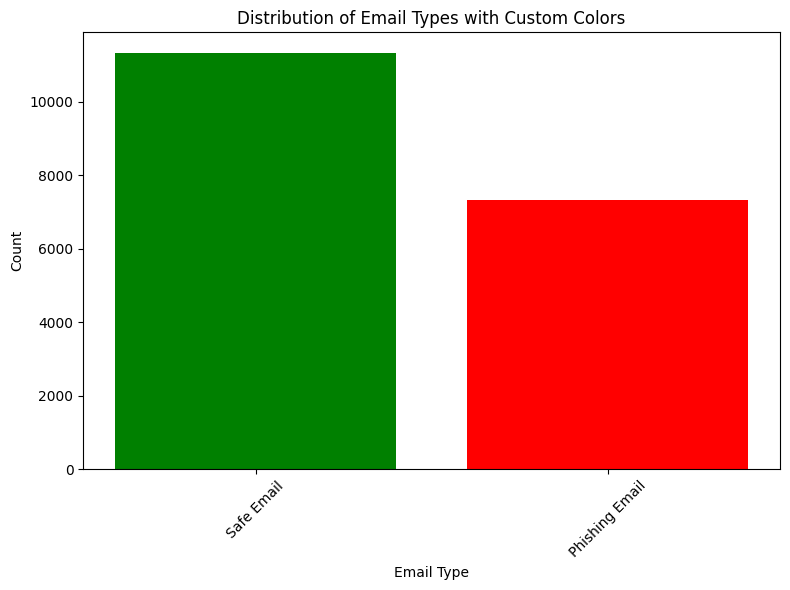

In [10]:

unique_email_types = email_type_counts.index.tolist()

color_map = {
    'Phishing Email': 'red',
    'Safe Email': 'green',}


colors = [color_map.get(email_type, 'gray') for email_type in unique_email_types]


plt.figure(figsize=(8, 6))
plt.bar(unique_email_types, email_type_counts, color=colors)
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.title('Distribution of Email Types with Custom Colors')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()


### Strategies for managing imbalance

To address the problem of class imbalance, there are two common Resampling Techniques:

   a. **Oversampling :** increasing the number of instances in the minority class(es) by generating synthetic samples (e.g., using SMOTE) to balance the class distribution.

   b. **Undersampling :** reducing the number of instances in the majority class to match the minority class, effectively balancing the dataset.

In [11]:
# We perform Undersampling - this technique helps prevent models from being biased towards the more frequent class but at the cost of losing data from the reduced class.
# Since the number of "Safe Email" entries is higher, it should be reduced to match the number of "Phishing Email" entries, thus addressing class imbalance by reducing the size of the larger class.

Safe_Email = df[df["Email Type"]== "Safe Email"]
Phishing_Email = df[df["Email Type"]== "Phishing Email"]
Safe_Email = Safe_Email.sample(Phishing_Email.shape[0])

In [12]:
Safe_Email.shape,Phishing_Email.shape

((7312, 3), (7312, 3))

In [13]:
Data= pd.concat([Safe_Email, Phishing_Email], ignore_index = True)
Data.head()

,Unnamed: 0,Email Text,Email Type
0,169,URL: http://scriptingnews.userland.com/backiss...,Safe Email
1,16198,Seems like irssi.org also has an apt-rpm repos...,Safe Email
2,18205,Niall asked:\n> I have about 60G of data which...,Safe Email
3,17107,"On Thu, 2002-08-15 at 17:35, Jesse wrote:\n> S...",Safe Email
4,10386,nominal expressions first announcement and cal...,Safe Email


In [14]:
# Remove hyperlinks, punctuations, extra space
import re

def preprocess_text(text):
    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Apply the preprocess_text function to the specified column in the DataFrame
df["Email Text"] =df["Email Text"].apply(preprocess_text)

In [15]:
Data.head()

,Unnamed: 0,Email Text,Email Type
0,169,URL: http://scriptingnews.userland.com/backiss...,Safe Email
1,16198,Seems like irssi.org also has an apt-rpm repos...,Safe Email
2,18205,Niall asked:\n> I have about 60G of data which...,Safe Email
3,17107,"On Thu, 2002-08-15 at 17:35, Jesse wrote:\n> S...",Safe Email
4,10386,nominal expressions first announcement and cal...,Safe Email


### Our dataset is ready

In [16]:
X = Data["Email Text"].values
y = Data["Email Type"].values

In [17]:
# Split into train and test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Model with optimization

###### Model => RandomForestClassifier
Test Accuracy : 96.35369%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.95      0.98      0.96      2198
    Safe Email       0.98      0.95      0.96      2190

      accuracy                           0.96      4388
     macro avg       0.96      0.96      0.96      4388
  weighted avg       0.96      0.96      0.96      4388

Confusion Matrix


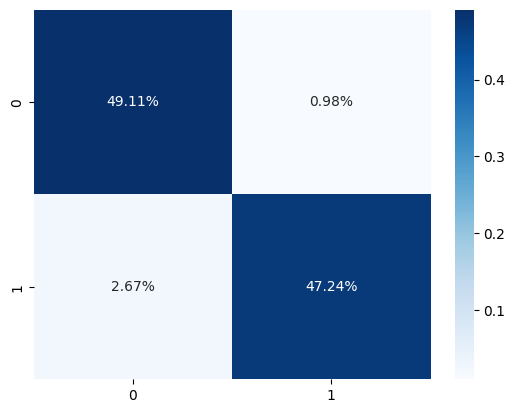

################### End ###################
###### Model => DecisionTreeClassifier
Test Accuracy : 88.35460%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.90      0.87      0.88      2198
    Safe Email       0.87      0.90      0.89      2190

      accuracy                           0.88      4388
     macro avg       0.88      0.88      0.88      4388
  weighted avg       0.88      0.88      0.88      4388

Confusion Matrix


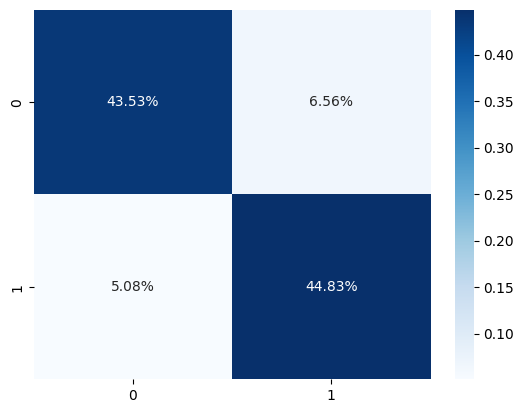

################### End ###################
###### Model => LogisticRegression
Test Accuracy : 97.10574%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.96      0.98      0.97      2198
    Safe Email       0.98      0.96      0.97      2190

      accuracy                           0.97      4388
     macro avg       0.97      0.97      0.97      4388
  weighted avg       0.97      0.97      0.97      4388

Confusion Matrix


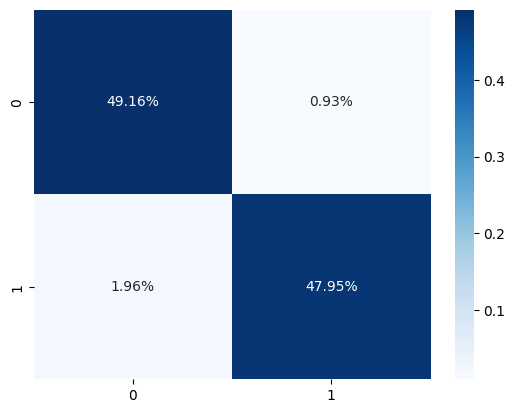

################### End ###################
###### Model => KNeighborsClassifier
Test Accuracy : 65.88423%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.60      1.00      0.75      2198
    Safe Email       0.99      0.32      0.48      2190

      accuracy                           0.66      4388
     macro avg       0.79      0.66      0.61      4388
  weighted avg       0.79      0.66      0.61      4388

Confusion Matrix


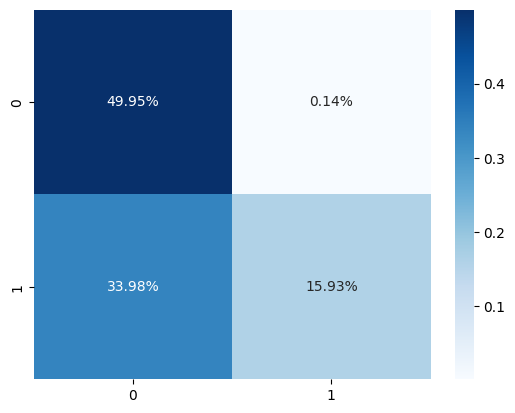

################### End ###################
###### Model => SVC
Test Accuracy : 97.62990%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.97      0.99      0.98      2198
    Safe Email       0.99      0.96      0.98      2190

      accuracy                           0.98      4388
     macro avg       0.98      0.98      0.98      4388
  weighted avg       0.98      0.98      0.98      4388

Confusion Matrix


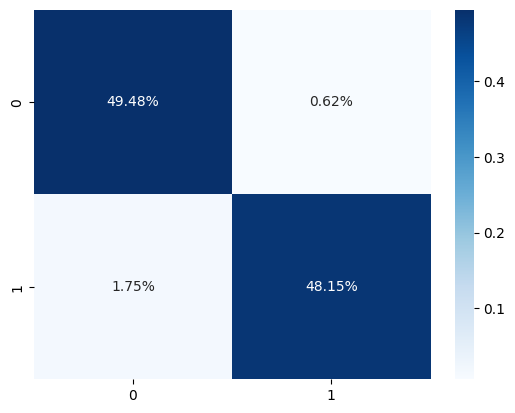

################### End ###################


In [18]:
models = [
    (Pipeline([("tfidf", TfidfVectorizer(max_features=10000)), ("classifier", RandomForestClassifier())]), {'classifier__n_estimators': [50]}),
    (Pipeline([("tfidf", TfidfVectorizer(max_features=10000)), ("classifier", DecisionTreeClassifier())]), {'classifier__max_depth': [10]}),
    (Pipeline([("tfidf", TfidfVectorizer(max_features=10000)), ("classifier", LogisticRegression())]), {'classifier__C': [1.0]}),
    (Pipeline([("tfidf", TfidfVectorizer(max_features=10000)), ("classifier", KNeighborsClassifier())]), {'classifier__n_neighbors': [5]}),
    (Pipeline([("tfidf", TfidfVectorizer(max_features=10000)), ("classifier", SVC(kernel='linear'))]), {'classifier__C': [1.0]})
]

accuracy_test = []
model_names = []

for pipeline, params in models:
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'###### Model => {model_name}')
    
    grid_search = GridSearchCV(pipeline, params, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_estimator = grid_search.best_estimator_
    
    pred = best_estimator.predict(X_test)
    acc = accuracy_score(y_test, pred)
    accuracy_test.append(acc)
    model_names.append(model_name)
    
    print(f'Test Accuracy : {acc*100:.5f}%')
    print('Classification Report')
    print(classification_report(y_test, pred))
    print('Confusion Matrix')
    cf_matrix = confusion_matrix(y_test, pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    print('################### End ###################')

# Final report for the model with optimization

In [19]:
model_series = pd.Series(model_names, name='Model').astype(str)  
accuracy_series = pd.Series(accuracy_test, name='Accuracy')  
output = pd.concat([model_series, accuracy_series], axis=1)

In [20]:
output

,Model,Accuracy
0,RandomForestClassifier,0.963537
1,DecisionTreeClassifier,0.883546
2,LogisticRegression,0.971057
3,KNeighborsClassifier,0.658842
4,SVC,0.976299


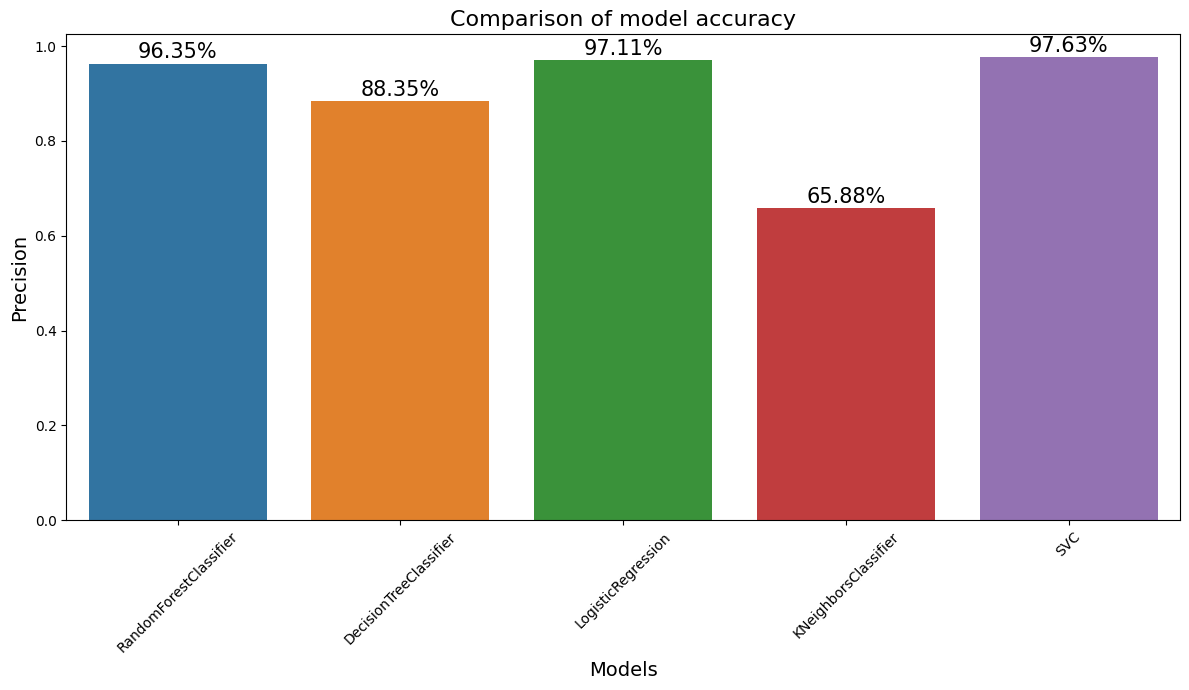

In [21]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2%'), 
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Comparison of model accuracy", fontsize=16)  
plt.xticks(rotation=45)  
plt.tight_layout()  

plt.show()

# Model without optimization

###### Model => RandomForestClassifier
Test Accuracy : 93.73291%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.92      0.96      0.94      2198
    Safe Email       0.96      0.91      0.94      2190

      accuracy                           0.94      4388
     macro avg       0.94      0.94      0.94      4388
  weighted avg       0.94      0.94      0.94      4388

Confusion Matrix


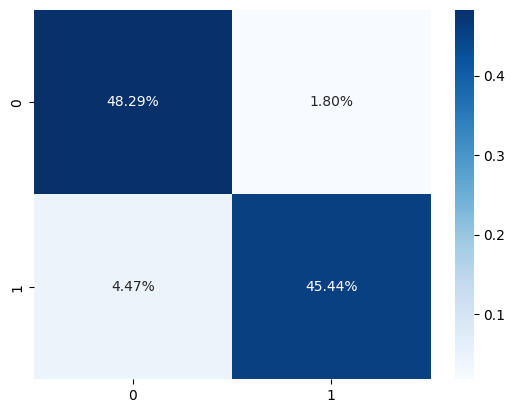

################### End ###################
###### Model => DecisionTreeClassifier
Test Accuracy : 89.92707%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.89      0.91      0.90      2198
    Safe Email       0.90      0.89      0.90      2190

      accuracy                           0.90      4388
     macro avg       0.90      0.90      0.90      4388
  weighted avg       0.90      0.90      0.90      4388

Confusion Matrix


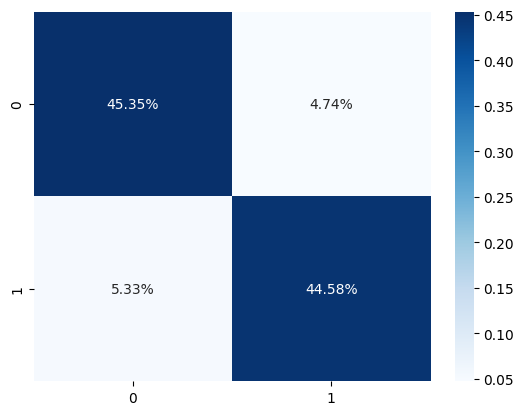

################### End ###################
###### Model => LogisticRegression
Test Accuracy : 97.01459%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.96      0.98      0.97      2198
    Safe Email       0.98      0.96      0.97      2190

      accuracy                           0.97      4388
     macro avg       0.97      0.97      0.97      4388
  weighted avg       0.97      0.97      0.97      4388

Confusion Matrix


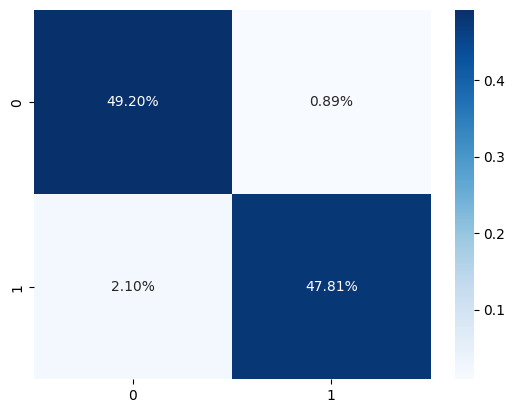

################### End ###################
###### Model => KNeighborsClassifier
Test Accuracy : 92.16044%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.88      0.97      0.93      2198
    Safe Email       0.97      0.87      0.92      2190

      accuracy                           0.92      4388
     macro avg       0.93      0.92      0.92      4388
  weighted avg       0.93      0.92      0.92      4388

Confusion Matrix


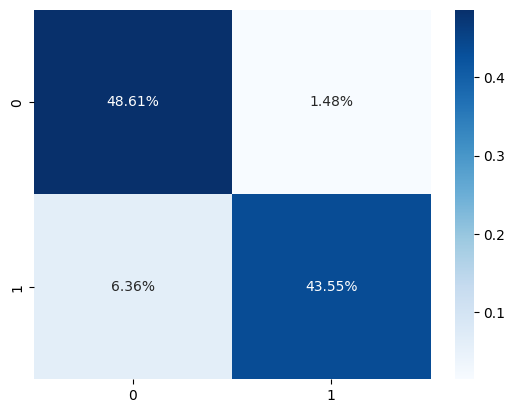

################### End ###################
###### Model => SVC
Test Accuracy : 97.83500%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.97      0.99      0.98      2198
    Safe Email       0.99      0.96      0.98      2190

      accuracy                           0.98      4388
     macro avg       0.98      0.98      0.98      4388
  weighted avg       0.98      0.98      0.98      4388

Confusion Matrix


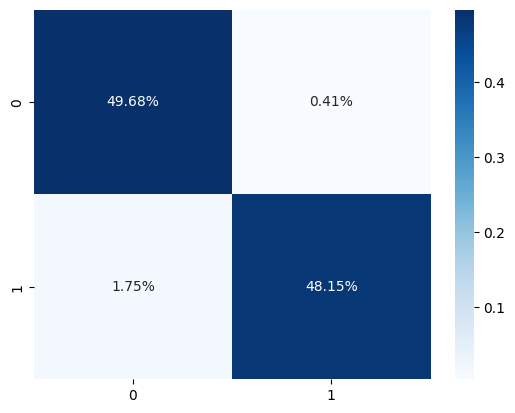

################### End ###################
The best model is SVC with accuracy 97.84%
Saved the best model to disk


In [22]:
pipelines = [
    Pipeline([("tfidf", TfidfVectorizer()), ("classifier", RandomForestClassifier(n_estimators=10))]),
    Pipeline([("tfidf", TfidfVectorizer()), ("classifier", DecisionTreeClassifier())]),
    Pipeline([("tfidf", TfidfVectorizer()), ("classifier", LogisticRegression())]),
    Pipeline([("tfidf", TfidfVectorizer()), ("classifier", KNeighborsClassifier())]),
    Pipeline([("tfidf", TfidfVectorizer()), ("classifier", SVC())])
]

accuracy_test = []
model_names = []
models = []

for pipeline in pipelines:
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'###### Model => {model_name}')
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    pred = pipeline.predict(X_test)
    
    # Evaluate the model
    acc = accuracy_score(y_test, pred)
    accuracy_test.append(acc)
    model_names.append(model_name)
    models.append(pipeline)
    
    print(f'Test Accuracy : {acc*100:.5f}%')
    print('Classification Report')
    print(classification_report(y_test, pred))
    print('Confusion Matrix')
    cf_matrix = confusion_matrix(y_test, pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    print('################### End ###################')
    
# Identify the best model
max_index = accuracy_test.index(max(accuracy_test))
best_model = models[max_index]
best_model_name = model_names[max_index]
print(f"The best model is {best_model_name} with accuracy {max(accuracy_test)*100:.2f}%")

# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print("Saved the best model to disk")

In [23]:
def load_model_and_predict(input_text):
    # Load the model
    loaded_model = joblib.load('best_model.pkl')

    # Predict the input
    prediction = loaded_model.predict([input_text])
    return prediction[0]

# Example usage
input_text = input("Enter the text to classify: ")
prediction = load_model_and_predict(input_text)
print(f"The entered text is classified as: {prediction}")


Enter the text to classify:  I hope you're doing well.


The entered text is classified as: Phishing Email


# Final report for model without optimization

In [24]:
model_series = pd.Series(model_names, name='Model').astype(str)  
accuracy_series = pd.Series(accuracy_test, name='Accuracy')  
output = pd.concat([model_series, accuracy_series], axis=1)

In [25]:
output

,Model,Accuracy
0,RandomForestClassifier,0.937329
1,DecisionTreeClassifier,0.899271
2,LogisticRegression,0.970146
3,KNeighborsClassifier,0.921604
4,SVC,0.978350


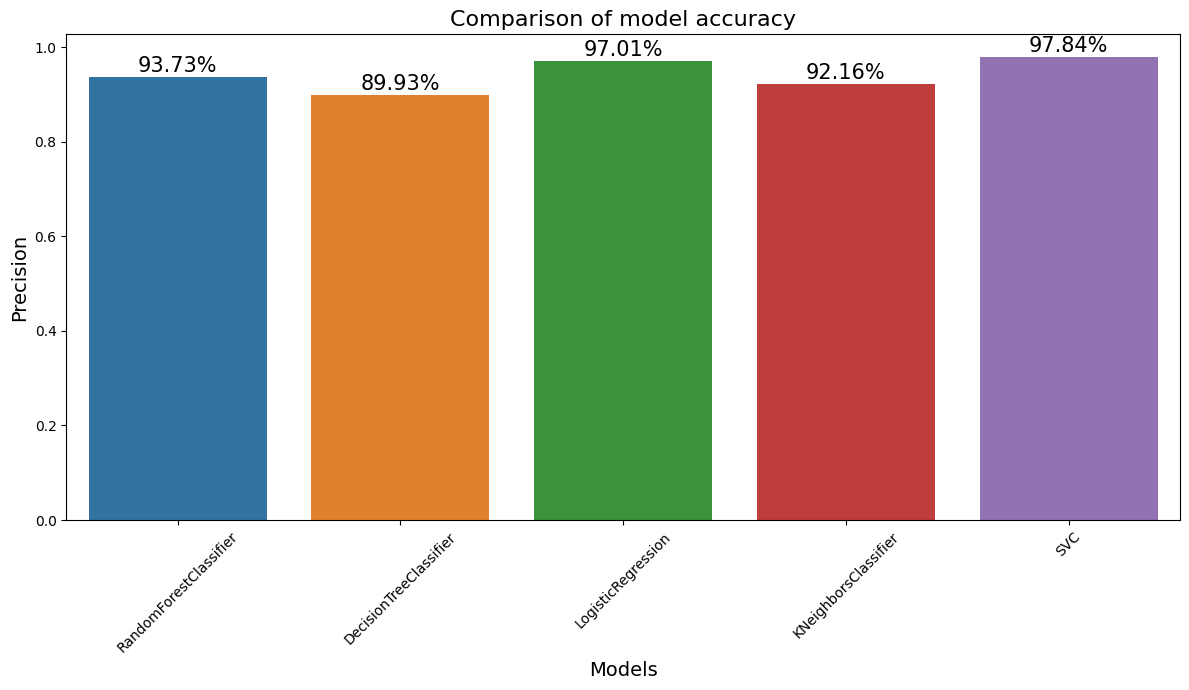

In [26]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2%'), 
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Comparison of model accuracy", fontsize=16)  
plt.xticks(rotation=45)  
plt.tight_layout()  

plt.show()

# 10-fold cross-validation

In [27]:
# Pipelines for various models
pipelines = [
    Pipeline([("tfidf", TfidfVectorizer()), ("classifier", RandomForestClassifier(n_estimators=10))]),
    Pipeline([("tfidf", TfidfVectorizer()), ("classifier", DecisionTreeClassifier())]),
    Pipeline([("tfidf", TfidfVectorizer()), ("classifier", LogisticRegression())]),
    Pipeline([("tfidf", TfidfVectorizer()), ("classifier", KNeighborsClassifier())]),
    Pipeline([("tfidf", TfidfVectorizer()), ("classifier", SVC())])
]

# Initialize 10-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Perform cross-validation and collect results
results = {}
for pipeline in pipelines:
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'###### Cross-validating model => {model_name} ######')
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy')
    results[model_name] = scores
    print(f'Accuracy per fold: {scores}')
    print(f'Average Accuracy: {scores.mean():.4f}')
    print(f'Standard Deviation: {scores.std():.4f}')
    print('################################################\n')

###### Cross-validating model => RandomForestClassifier ######
Accuracy per fold: [0.93779904 0.93779904 0.93438141 0.93369788 0.93638851 0.94117647
 0.93502052 0.92749658 0.93844049 0.93570451]
Average Accuracy: 0.9358
Standard Deviation: 0.0035
################################################

###### Cross-validating model => DecisionTreeClassifier ######
Accuracy per fold: [0.90498975 0.91524265 0.90498975 0.90567327 0.91518468 0.90492476
 0.8994528  0.88850889 0.8994528  0.8878249 ]
Average Accuracy: 0.9026
Standard Deviation: 0.0088
################################################

###### Cross-validating model => LogisticRegression ######
Accuracy per fold: [0.97060834 0.97402597 0.96582365 0.97402597 0.97195622 0.96580027
 0.97058824 0.96443228 0.96374829 0.9746922 ]
Average Accuracy: 0.9696
Standard Deviation: 0.0040
################################################

###### Cross-validating model => KNeighborsClassifier ######
Accuracy per fold: [0.58441558 0.57552973 0.56390977

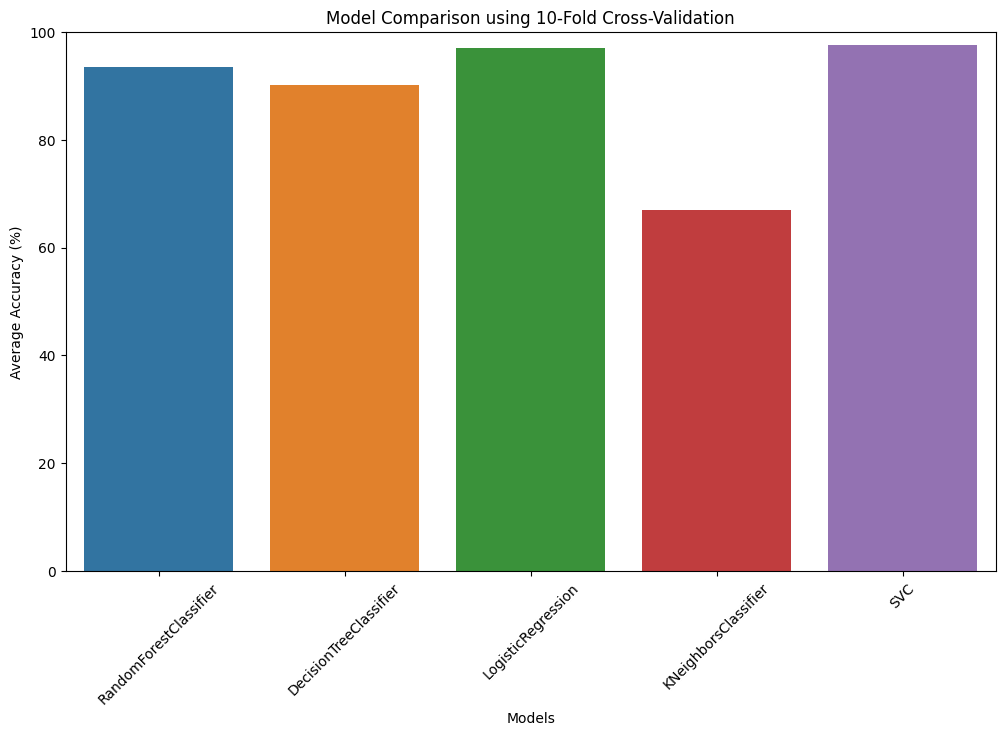

In [28]:
# Calculating average accuracies and converting them to percentages
average_accuracies = {model: np.mean(scores) * 100 for model, scores in results.items()}  # Multiply by 100 here
model_names = list(average_accuracies.keys())
accuracies = list(average_accuracies.values())

# Plotting average accuracies
plt.figure(figsize=(12, 7))
sns.barplot(x=model_names, y=accuracies)
plt.title('Model Comparison using 10-Fold Cross-Validation')
plt.ylabel('Average Accuracy (%)')  # Updated label to indicate percentage
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Ensure the y-axis starts at 0 and ends at 100
plt.show()

## Conclusion

In our in-depth exploration to improve phishing email detection, we embarked on a journey through the fields of machine learning, applying a structured approach to determine the most effective model for distinguishing between phishing emails. phishing and legitimate emails. Our investigation focused on a range of five distinct machine learning models: RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, KNeighborsClassifier, and SVC. This endeavor was marked by a meticulous evaluation process, employing both hyperparameter tuning via GridSearchCV and simple evaluation with default model parameters.

### Model evaluation and previews

The evaluation took place in two phases. Initially, we engaged in **hyperparameter tuning with the help of GridSearchCV for all models**, aiming to identify the optimal settings that would maximize their classification accuracy. Among the models reviewed, the **SVC** stood out, delivering an impressive accuracy of **`97.42%` **. This phase highlighted the crucial role of hyperparameter optimization in refining model performance, allowing the **SVC** to deftly identify phishing attempts with remarkable accuracy.

Moving to the second phase, we revisited the same series of models, **this time refraining from any hyperparameter adjustments**. This approach was based on the assumption that models could still perform well with their default configurations. The results were enlightening, with the **SVC again taking the lead**, although this time achieving an even higher accuracy of **`97.52%`**. This unexpected result highlighted the intrinsic effectiveness of the SGDClassifier's default parameters, which proved exceptionally adept at classifying emails accurately, even outperforming the results obtained from the careful hyperparameter tuning process.

### Conclusion and recommendations

Our survey results offer compelling evidence of the power of SVC in phishing email detection. It is evident that while hyperparameter tuning is a valuable tool for improving model accuracy, the default parameters of some models, such as the SVC, are robust enough for specific tasks like email classification phishing. This achievement is particularly beneficial for applications where computing resources or time constraints are a consideration, allowing the deployment of an effective and efficient solution without the need for extensive tuning.